In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import models
from torchvision.models import resnet18
from torchsummary import summary

import medmnist
from medmnist import INFO, PneumoniaMNIST
from medmnist import Evaluator
from PIL import Image

from tqdm import tqdm #fancy progress bar
import numpy as np
import shap
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns
import gc

import copy

from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from scipy.ndimage import zoom

import random


# ALL the random seeds for full reproducibility! Or atleast as many i know of
random.seed(42)
np.random.seed(42)
torch.manual_seed(42) #https://docs.pytorch.org/docs/stable/generated/torch.manual_seed.html
if torch.cuda.is_available(): #I think these makes use of same configuration of gpus on each run
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True #https://docs.pytorch.org/docs/stable/backends.html#torch.backends.cudnn.deterministic Deterministic cnns

# Seting up Data

In [2]:

BATCH_SIZE = 128//2  # hyperparam for batches. I dont like the spatial separation of hyperparams but this is how pytorch works

# Get dataset information
data_flag = 'pneumoniamnist'
info = INFO[data_flag]  # This gets the dataset metadata
# n_channels = info['n_channels']
# n_classes = len(info['label'])

# copied from getting started
# This tells pytorch what to download.
DataClass = getattr(medmnist, info['python_class'])

# data preprocessing steps, copied from getting started
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image or numpy array to tensor
    transforms.Normalize(mean=[.5], std=[.5])  # Scale to [-1, 1] range
])

# Load the datasets also copied from getting started
train_dataset = DataClass(split='train', transform=data_transform, download=True)  
test_dataset = DataClass(split='test', transform=data_transform, download=True)  
# download=True "downloads the data from the internet" https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
# needed if i want to run locally rather than collab


# worker init function for full reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32 #Weird calculation is to ensure seed fits into 32 bit seeds, overflow protection
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator() #https://docs.pytorch.org/docs/stable/generated/torch.Generator.html
g.manual_seed(42) #Fixing the seed 

# Create data loaders
# Dataloaders are a separate class that takes in the batch size argument and the class "feeds" the nn with one batch of data at a time
# This is supposed to be cleaner because you can switch what kind of data and tune batch size easier. 
# But I need to read more on this topic to be totally clear on why
train_loader = data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    worker_init_fn=seed_worker, #trying to stabilize whatever randomization i can
    generator=g #trying to make sure the random shuffling is constant across reruns
)
#this is also training data but not shuffled for training evaluation, wheras train loader shuffles data for more robust training
train_loader_at_eval = data.DataLoader(
    dataset=train_dataset, 
    batch_size=2*BATCH_SIZE, 
    shuffle=False  # False for evaluation
)
#test
test_loader = data.DataLoader(
    dataset=test_dataset, 
    batch_size=2*BATCH_SIZE, 
    shuffle=False  # False for testing
)

print("Summary of the problem")
print(f"Task: {info['task']}")
print(f"Class labels: {info['label']}")

Summary of the problem
Task: binary-class
Class labels: {'0': 'normal', '1': 'pneumonia'}


### Getting some images

class [1]


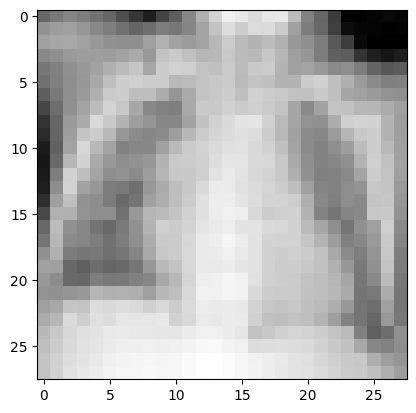

In [3]:
img_dataset = DataClass(split='train', download=True)  # If i remove data_transform i can get images
print("class", img_dataset[0][1])
plt.imshow(img_dataset[0][0], cmap="gray") #for some reason i messed around a lot not getting color right until i remembered its grayscale
plt.show()

According to docs 0 is normal 1 is pneumonia  
https://www.tensorflow.org/datasets/catalog/pneumonia_mnist

class [0]


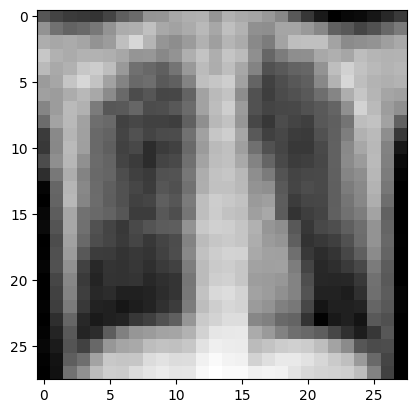

In [4]:
for i in range(len(img_dataset)):
    if img_dataset[i][1]==0: #finding the first non pneumonia/healthy xray
        print("class", img_dataset[i][1])
        plt.imshow(img_dataset[i][0], cmap="gray")
        plt.show()
        break

This one has more dark in their lungs but is also straighter and thinner compared to first image.  
I have no idea if this is due to pneumonia or individual variation from tilted body in xray machine and/or different body shape of patient.  

In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/carlraask/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /home/carlraask/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0':

### Setting up model

In [6]:
# More hyperparams
lr=0.01/2
momentum=0.9/2
#tried searching for some kind of default but it seems to be a range
#https://www.researchgate.net/figure/The-hyper-parameters-choices-for-ResNet18_tbl2_339580876
NUM_EPOCHS=5+3 #5-50 seems like a good starting number for a pretrained nn.


model = models.resnet18(weights="DEFAULT") #Default = pretrained weights according to docs
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights

#Change the first convolutional layer to accept 1 channel (greyscale) instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#Final layer fix
model.fc = nn.Linear(model.fc.in_features, 2) 

model = model.cuda() if torch.cuda.is_available() else model 
#Checking if gpu is available 
# (it is on my comp and might accidently end up default at other spots)

### Printouts of model for layer analyziation

In [7]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

11,171,266 params= weights used and updated each epoch + 17 relus of each X + 20 batch norms of each X. + However many steps each conv has to do ~a ton of calculations!


In [8]:
#This is overkill but fun

# from torch.utils.tensorboard import SummaryWriter
# import torch

# # Create writer
# writer = SummaryWriter('runs/experiment')

# # Model to CPU for visualization (easier)
# model_cpu = model.cpu()

# # Add graph
# x = torch.randn(1, 1, 28, 28)
# writer.add_graph(model_cpu, x)
# writer.close()

# print("Graph saved. Run in terminal: tensorboard --logdir=runs")

### Freeze!
Ref: https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598  
Has to be done before setting up optimizer and training

In [9]:
all_the_layers=[]
for name, layer in model.named_children():
    all_the_layers.append(name)
all_the_layers

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

Note avgpool, maxpool, relu and bn1 don't have any weights so slicing has to be mindful of this

In [10]:
# # Freeze layers
# #https://docs.pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html
# for name, layer in model.named_children():
#     if name in all_the_layers[:-1]:
#         for param in layer.parameters():
#             param.requires_grad = False #shorthand for "dont update gradients in tensor during backward pass"
# #confirming whether frozen
# for name, param in model.named_parameters():
#     if param.requires_grad: #requires_grad = "shorthand for gradients will update"
#         print(name)


# Setting up training

In [11]:
#Had to remake test code from getting_started since im stubborn and want to be in vsc and use my own gpu


def pred_eval(split = "train", evaluate=False, cm_indices=True):

    model.eval() #turning off batch norm etc for eval https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
    #overfit checking
    if split == "train":
        data_loader = train_loader_at_eval  
    elif split == "test":
        data_loader = test_loader  


    # lists to collect predicted labels and probabilities
    all_targets = []
    all_outputs = []

    with torch.no_grad(): #no grad = "Just do a forward pass so we can evaluate"
        for inputs, targets in data_loader:
            inputs = inputs.cuda() #Making sure we still in gpu land
            outputs = model(inputs) #pass data through model
            outputs = torch.softmax(outputs, dim=1) #softmax to select most probable class
            
            #change data to cpu so numpy can handle the later
            all_targets.append(targets.cpu()) 
            all_outputs.append(outputs.cpu())

    # Converting to proper format
    y_true = torch.cat(all_targets, 0)  # 1d tensor == 1d vector
    y_score = torch.cat(all_outputs, 0)  # 2d tensor == each row is a sample with proba for class 0 and 1 respectivley

    y_pred = np.argmax(y_score, axis=1) #get the biggest pred and convert to predicted labels
    if evaluate==False:
        return y_pred, y_true, y_score

    else:
        evaluator = Evaluator(data_flag, split, size=28)
        metrics = evaluator.evaluate(y_score) 
        print(f'Accuracy: {metrics.ACC:.4f}')
        
    
        if cm_indices==True:
            #tetting up lists to store cm matrix indices for later shap eval
            tp_indices = []
            fp_indices = []
            tn_indices = []
            fn_indices = []


            print(f"\nFirst 5 samples:")
            for i in range(len(y_true)):
                #printing the first 5 true labels, predictions and probabilities
                if i >= 5:
                    pass
                else:
                    print(f"Sample {i}: True={y_true[i]}, Pred={y_pred[i]}, Probs=[{y_score[i,0]:.3f}, {y_score[i,1]:.3f}]")
                #collecting cm matrix indices for later shap eval
                if y_true[i] == 1 and y_pred[i] == 1:
                    tp_indices.append(i)
                elif y_true[i] == 0 and y_pred[i] == 1:
                    fp_indices.append(i)
                elif y_true[i] == 0 and y_pred[i] == 0:
                    tn_indices.append(i)
                elif y_true[i] == 1 and y_pred[i] == 0:
                    fn_indices.append(i)
                    
            print(f"TP: {len(tp_indices)}, FP: {len(fp_indices)}, TN: {len(tn_indices)}, FN: {len(fn_indices)}")
            return y_pred, y_true, y_score ,tp_indices,fp_indices,tn_indices,fn_indices
        
        else:
            return y_pred, y_true, y_score

# Testing code        
#tn_indices,fn_indices = pred_eval(split = 'test', evaluate=True, cm_indices=False)
#y_pred, y_true = pred_eval(split = 'test')
#print("great sucess")
# y_pred, y_true= pred_eval(split = 'train', evaluate=True, cm_indices=False)
# print("great sucess")
# y_pred, y_true,tp_indices,fp_indices,tn_indices,fn_indices = pred_eval(split = 'test', evaluate=True, cm_indices=True)
# print("great sucess")

In [12]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
#idk why not sigmoid and log loss for a simple binary clf doesnt exist in pytorch

#default from getting started. Stochastic gradient descent. 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [13]:
# train copied from getting started but removed "if task == 'multi-label, binary-class:...." since its not needed for this dataset
# also removed the 4 counting variables since they dont seem to be used anywhere and didnt break anything
for epoch in range(NUM_EPOCHS):
    model.train() #"dont forget to turn on train after eval" https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
    for inputs, targets in tqdm(train_loader): #fancy progress bar with tqdm
        # forward + backward + optimize
        optimizer.zero_grad()#"Reset the gradients of all optimized torch.Tensors." according to docs
        #if this isnt done then gradient values will += each round and accumulate in magnitude
        outputs = model(inputs.cuda()) #run the model
       
        targets = targets.cuda() #making sure we still in gpu land
        
        targets = targets.squeeze().long() #true labels
        #squeeze removes any dimensions that == 1, can specify wich index, if empty removes all dim==1
        #long converts to int64 for cross entopy
        loss = criterion(outputs, targets) #hyperparam input
        
        loss.backward() #compute DL/dx step for every x
        optimizer.step() #take one gd step based on lr and momentum
    print("train")
    y_pred_tr, y_true_tr, y_score_tr= pred_eval(split = 'train', evaluate=True, cm_indices=False)
    print("test")
    y_pred_te, y_true_te, y_score_te= pred_eval(split = 'test', evaluate=True, cm_indices=False)




100%|██████████| 74/74 [00:01<00:00, 55.36it/s]


train
Accuracy: 0.9605
test
Accuracy: 0.8333


100%|██████████| 74/74 [00:01<00:00, 71.40it/s]


train
Accuracy: 0.9771
test
Accuracy: 0.8269


100%|██████████| 74/74 [00:01<00:00, 71.32it/s]


train
Accuracy: 0.9730
test
Accuracy: 0.8253


100%|██████████| 74/74 [00:01<00:00, 70.82it/s]


train
Accuracy: 0.9839
test
Accuracy: 0.8462


100%|██████████| 74/74 [00:01<00:00, 68.94it/s]


train
Accuracy: 0.9938
test
Accuracy: 0.8814


100%|██████████| 74/74 [00:01<00:00, 71.31it/s]


train
Accuracy: 0.9885
test
Accuracy: 0.8285


100%|██████████| 74/74 [00:01<00:00, 71.78it/s]


train
Accuracy: 0.9996
test
Accuracy: 0.8558


100%|██████████| 74/74 [00:01<00:00, 71.63it/s]


train
Accuracy: 0.9964
test
Accuracy: 0.8750


Accuracy: 0.8750

First 5 samples:
Sample 0: True=tensor([1]), Pred=1, Probs=[0.000, 1.000]
Sample 1: True=tensor([0]), Pred=1, Probs=[0.009, 0.991]
Sample 2: True=tensor([1]), Pred=1, Probs=[0.012, 0.988]
Sample 3: True=tensor([0]), Pred=0, Probs=[1.000, 0.000]
Sample 4: True=tensor([1]), Pred=1, Probs=[0.000, 1.000]
TP: 376, FP: 64, TN: 170, FN: 14


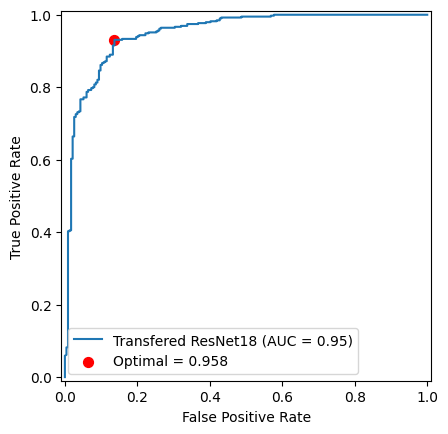

AUC: 0.950
Optimal threshold: 0.958
At threshold 0.958:
  Sensitivity: 0.931
  Specificity: 0.863


In [14]:



y_pred, y_true, y_score ,tp_indices,fp_indices,tn_indices,fn_indices= pred_eval(split = 'test', evaluate=True, cm_indices=True)



# Extract probabilities for pneumonia class (class 1)
y_scores = y_score_te[:, 1]  # Probability of pneumonia

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_te, y_scores)
#false positive rate, true positive rate, descending thresholds

#https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
#copied and adjusted code from this one to find optimal
optimal_idx = np.argmax(tpr - fpr) #Meaning: We accept 1 False positive for 2 True positives
optimal_threshold = thresholds[optimal_idx]
roc_auc = auc(fpr, tpr)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                              estimator_name=f"Transfered ResNet18")
roc_display.plot()
#adding optimal spot
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=50, 
            label=f'Optimal = {optimal_threshold:.3f}')
plt.legend()
plt.show()


print(f"AUC: {roc_auc:.3f}")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"At threshold {optimal_threshold:.3f}:")
print(f"  Sensitivity: {tpr[optimal_idx]:.3f}")
print(f"  Specificity: {1-fpr[optimal_idx]:.3f}")

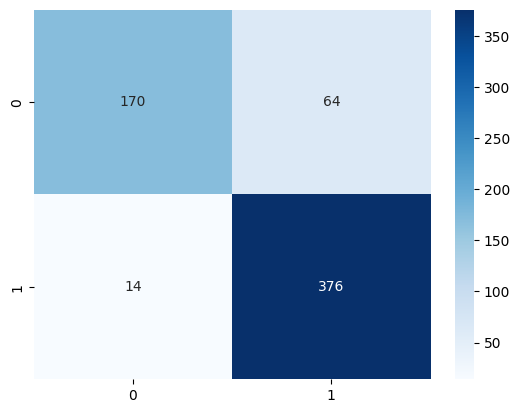

In [15]:

cm=confusion_matrix(y_true_te, y_pred_te)
sns.heatmap(cm, annot=True,fmt='.3g', cmap="Blues") #I was silly and tested several colors here. Very important.
#But blues felt the most neutral
plt.show()

# Statistical testing of original compared to tuned hyperparmeters

In [16]:
from scipy.stats import chi2_contingency
import numpy as np

# Contingency table:
table = np.array([[545, 79],   # Original: correct, incorrect (written in report)
                  [546, 78]])  # Tuned: correct, incorrect

chi2, p_value, dof, expected = chi2_contingency(table)
print(f"Chi-square: {chi2:.6f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")

Chi-square: 0.000000
p-value: 1.000000
Degrees of freedom: 1


# Shap

### Setting up targets to analyze

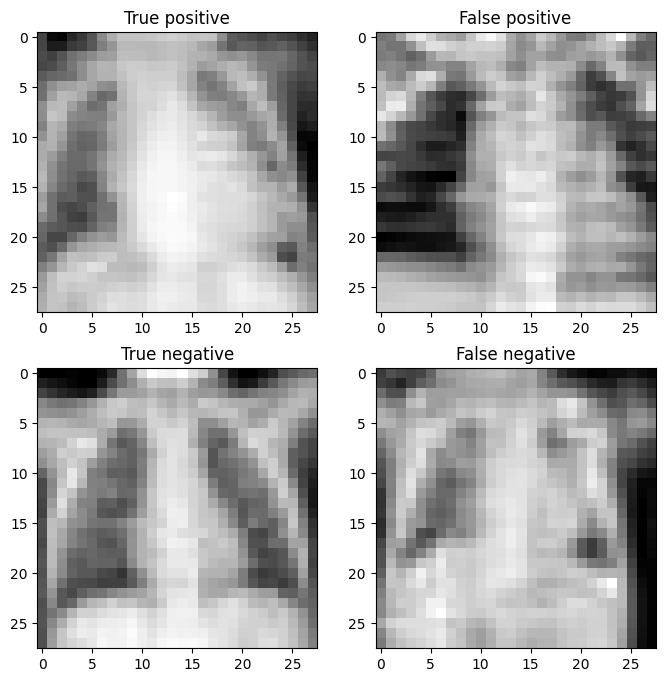

In [17]:
img_dataset_test = DataClass(split='test', download=True)

tp_image=img_dataset_test[tp_indices[0]]
fp_image=img_dataset_test[fp_indices[0]]
tn_image=img_dataset_test[tn_indices[0]]
fn_image=img_dataset_test[fn_indices[0]]

cm_images_pil=[]
cm_images_pil.append(tp_image)
cm_images_pil.append(fp_image)
cm_images_pil.append(tn_image)
cm_images_pil.append(fn_image)

fig, ax = plt.subplots(2,2,figsize=(8, 8))
ax[0,0].imshow(tp_image[0], cmap="gray")
ax[0,0].set_title("True positive") 
ax[0,1].imshow(fp_image[0], cmap="gray") 
ax[0,1].set_title("False positive") 
ax[1,0].imshow(tn_image[0], cmap="gray") 
ax[1,0].set_title("True negative") 
ax[1,1].imshow(fn_image[0], cmap="gray") 
ax[1,1].set_title("False negative") 
plt.show()

I cant tell any difference. Lets see if shap tells us what model looks at.

## Gradientexplainer

In [18]:
# A small set of representative images that define what “ordinary input” looks like.
background_list = []
for i in range(len(train_dataset)//4): #idk quarter of images should do? Noone explains how many to use
    #I guess I should limit this on bigger pictures and larger datasets
    img_tensor, _ = train_dataset[i] # extracting tensors
    background_list.append(img_tensor)
background = torch.stack(background_list).cuda() #gpu time again

# Finding our confusion matrix images in tensor format
test_images_list = []
for idx in [tp_indices[0], fp_indices[0], tn_indices[0], fn_indices[0]]:
    img_tensor, _ = test_dataset[idx]
    test_images_list.append(img_tensor)
test_images = torch.stack(test_images_list).cuda() #.stack() makes a cue of images to work through for comparison. Never leave home without gpu

# make explainers
model_explainer = shap.GradientExplainer(model, background)
model_shap_values = model_explainer.shap_values(test_images)  # Output shape: (4, 1, 28, 28, 2)

#Because im stupid ill do 2 layers too. One early and one late. Good thing i printed out those back then.
layer1_explainer = shap.GradientExplainer((model, model.layer1), background)
layer1_shap_values = layer1_explainer.shap_values(test_images)  

layer4_explainer = shap.GradientExplainer((model, model.layer4), background)
layer4_shap_values = layer4_explainer.shap_values(test_images)  

Shaps for pred=1


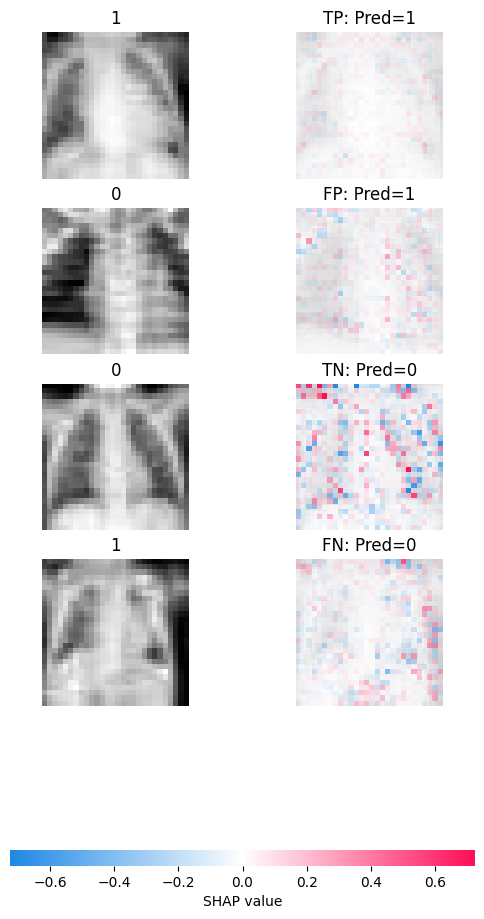

Shaps for pred=0


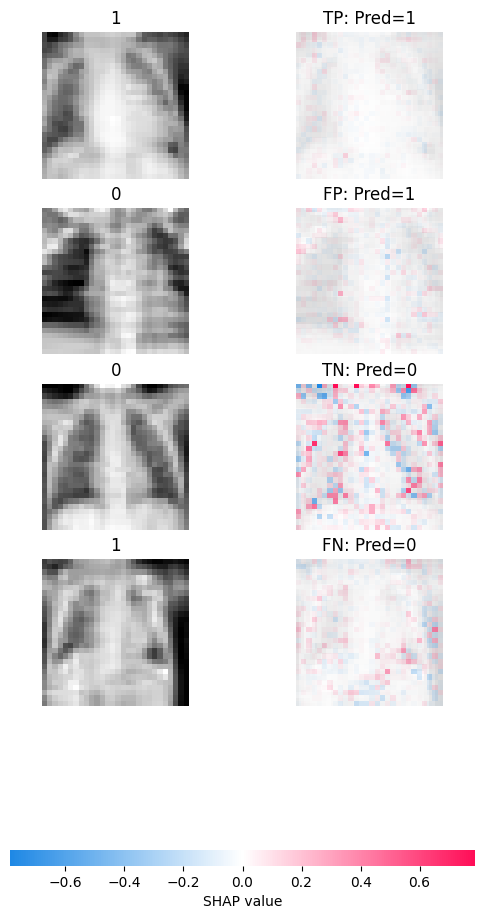

In [19]:
#This is the funky part one should check markdown below for understanding.

def plot_gradient_model(clf,shap_vals, images):
    test_images=images
    # Extract SHAP values for class n
    model_shap_vals = shap_vals[:, :, :, :, clf]  # Shape: (4, 1, 28, 28)

    # Convert test images for plotting
    test_images_plot = test_images.cpu().numpy()  # (4, 1, 28, 28)

    # Remove channel dimension for grayscale
    test_images_plot = test_images_plot.squeeze(1)  # (4, 28, 28)
    model_shap_vals = model_shap_vals.squeeze(1)  # (4, 28, 28)

    # Images were normalized with transforms.Normalize(mean=[0.5], std=[0.5]) for a run through the nn
    # need to denormalize back to [0, 1]
    test_images_plot = test_images_plot * 0.5 + 0.5  
    # I guess i could grab images from pil image version of dataset intead but i feel i wrangled enugh for now

    labels = ['TP: Pred=1', 'FP: Pred=1', 'TN: Pred=0', 'FN: Pred=0']
    true_labels = [1, 0, 0, 1]

    # Bit of a hack job since shap.image_plot needs matching dims in a specific order.
    # This is not mentioned in docs but the we examples i found did similar things. See refs at the top.
    test_images_plot=test_images_plot[:, :, :, np.newaxis] # (4, 28, 28, 1) matching dims with what img plot needs
    model_shap_vals=model_shap_vals[:, :, :, np.newaxis] # (4, 28, 28, 1) 


    plot= shap.image_plot(model_shap_vals, test_images_plot, labels=labels, true_labels=true_labels)
    return plot, test_images_plot, model_shap_vals

print("Shaps for pred=1")
plot_1, test_images_plot,model_shap_vals = plot_gradient_model(1,model_shap_values,test_images)
print("Shaps for pred=0")
plot_0, _,__ = plot_gradient_model(0,model_shap_values,test_images)

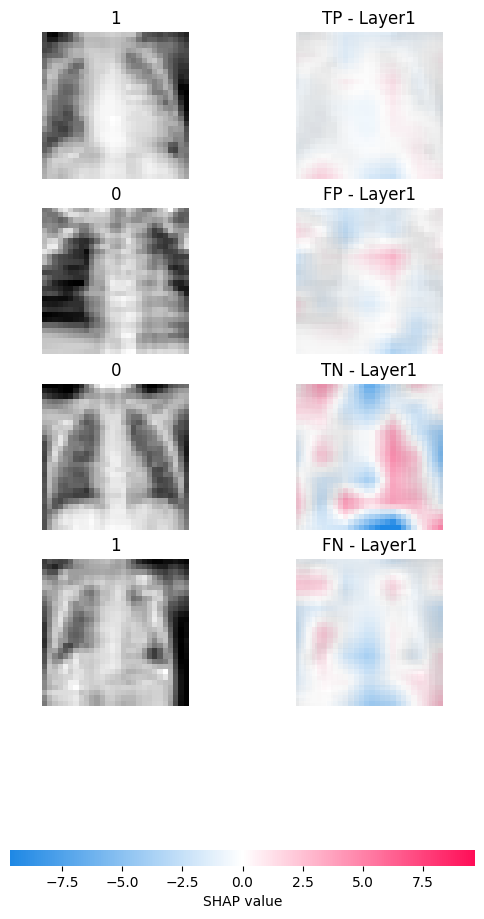

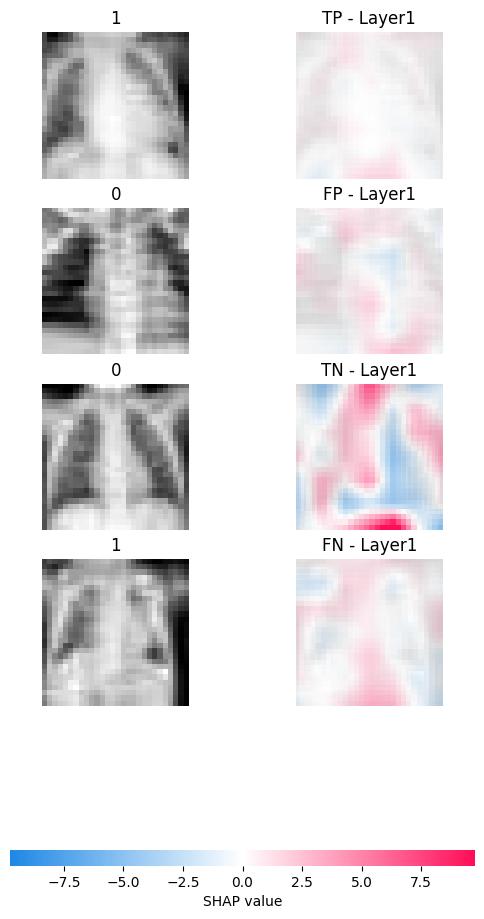

In [20]:
#After hours of work and digging and testing i got the TLDR for image_plot:
# Do what you can to make your layer dimensions fit your image dimensions
# This is not shown in docs as img_plot examples either conveniently uses layers that fit image or close enough for img_plot to handle
def plot_layer_1(clf, dim_imgs, layer1 ):
    #reusing images from earlier plots to save space

    #exctract class from vals as before. But!
    layer1 = layer1[:, :, :, :, clf].sum(axis=1) #Aggregate results across all 64 dimensions/channels
    #meaning we go from (4, 64, 7, 7) to (4, 7, 7)
    # I think sum or mean would end up pretty much the same as a given "pixel" for shap is pushing in either direction
 
    # Upsample from 7x7 to 28x28
    layer1 = zoom(layer1, (1, 4, 4), order=1)  # (4, 28, 28)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html
    #some automatic interpolation with this methid
    layer1=layer1[:, :, :, np.newaxis] # (4, 28, 28, 1) matching dims with what img plot needs
    # Plot
    shap.image_plot(layer1, dim_imgs,
                    labels=['TP - Layer1', 'FP - Layer1', 'TN - Layer1', 'FN - Layer1'], true_labels=[1, 0, 0, 1])


plot_layer_1(1, test_images_plot,layer1_shap_values )
plot_layer_1(0, test_images_plot,layer1_shap_values )

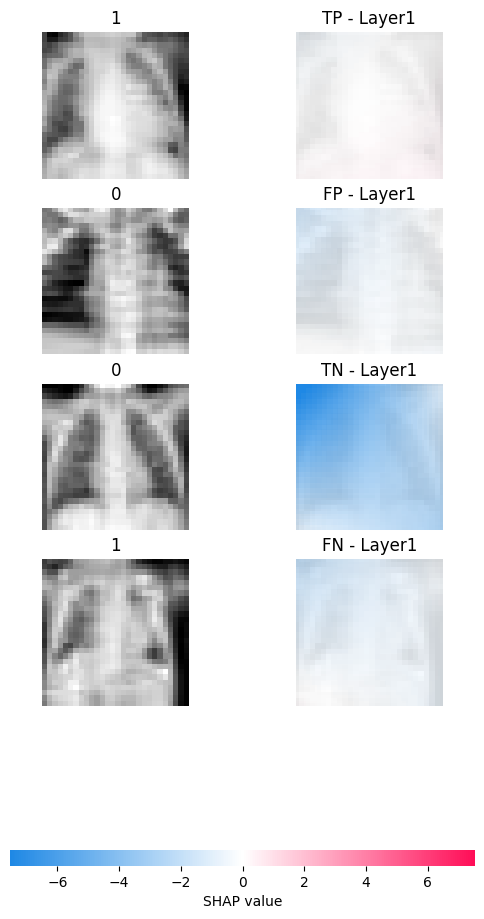

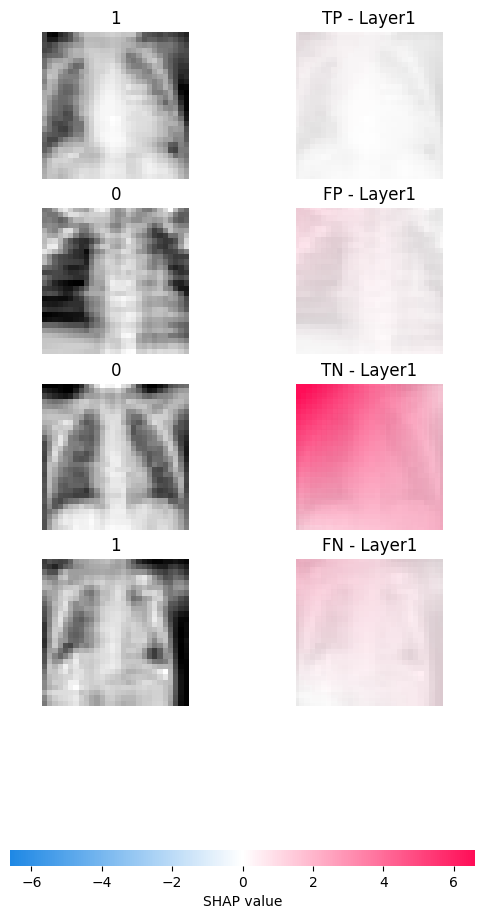

In [21]:
def plot_layer_4(clf, rgb_img):
    # Extract class again
    layer_4 = layer4_shap_values[:, :, :, :, clf].sum(axis=1) #We go from (4, 256, 2, 2) to (4, 2, 2)
  
    # This time we upsample from 2x2 to 28x28
    layer_4 = zoom(layer_4, (1, 14, 14), order=1)  # (4, 28, 28)
    # x14 means theres some serious interpolation going on here. 
    # Better to just mentally sum color intensity*area for these plots

    layer_4=layer_4[:, :, :, np.newaxis] # (4, 28, 28, 1) again!
    
    # Plot
    shap.image_plot(layer_4, rgb_img,
                    labels=['TP - Layer1', 'FP - Layer1', 'TN - Layer1', 'FN - Layer1'], true_labels=[1, 0, 0, 1])

plot_layer_4(1, test_images_plot )
plot_layer_4(0, test_images_plot )

# Bonus! 
## In the sense that I sortof solved these 2 before project description changed from "Partition and deepexplainer" to "Gradient explainer"

## Partitionexplainer  


In [22]:
#https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html
#according to docs i need a prediction with preprocessing. 
# The preprocessing consist of the same type of shape mangling as before

model.eval()

def partition_predict(x):
    # x values coming from SHAP: (batch, height, width, channels) = (N, 28, 28, 1)
    # now we need to reshape into something that works with resnet
    x = torch.tensor(x).float().permute(0, 3, 1, 2)  # → (N, 1, 28, 28)
    # this was a handy little "move the indexes around" method. 
    # I wonder if it would have worked on the earlier stuff, rather than all the squeezing and newaxis stuff
    #https://docs.pytorch.org/docs/stable/generated/torch.permute.html 


    device = next(model.parameters()).device #It is cuda though!
    x = x.to(device) #need to make the tensor gpu friendly again

    with torch.no_grad():
        outputs = model(x)  # This is according to doc link above
        #I dont know why no softmax etc but I guess from earlier code on classifiers we want logits rather than classes
    
    return outputs.cpu().numpy()  

In [23]:
topk = 2 #Explain top 2 classes. We have binary classification
batch_size = 100 # n concurrent shap evaluations. Big value=faster calculation but eats vram in this case. 
#Going to drop these from memory later
n_evals = 300 #how many pixel combinations will be perturbed? High=better graniluarity but more compute

# Making sure dimensions fit shap
raw_img = train_dataset.imgs[1]  

# starting with (H, W)
raw_img = raw_img[:, :, np.newaxis]  # Add channel for greyscale: (H, W, C)

# Masker= Blur out proportions of the imput image --> Analogous to marginal contribution for images
masker_blur = shap.maskers.Image("blur(28,28)", raw_img.shape) 
# I have no idea what to put here as we had no lectures on this topic so ill just take the shape of the images
# https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html#shap.maskers.Image

explainer = shap.Explainer(partition_predict, masker_blur) 
#predict function in this case is analogous to putting in your trained model in reg/clf task

# Run SHAP
def partitionshap(explainer, raw_img,n_evals):
    shap_values = explainer(
        raw_img[np.newaxis, :, :, :],  # Add dimension for class prediction. (1, 28, 28, 1)
        # For some reason its supposed to be first here. But in plot_img it was the last in the img plots...
        max_evals=n_evals,
        batch_size=batch_size,
        outputs=shap.Explanation.argsort.flip[:topk],
    )
    return shap_values
# Testcode for 1 img
# shap_values_test=partitionshap(explainer=explainer, raw_img=raw_img, n_evals=n_evals)
# print(shap_values_test.data.shape,"Shapvals, H, W, C")
# print(shap_values_test.values.shape, "Shapvals, H, W, C, num_classes")
# shap.image_plot(shap_values_test)

Image 0, True label: [1], Prediction 1


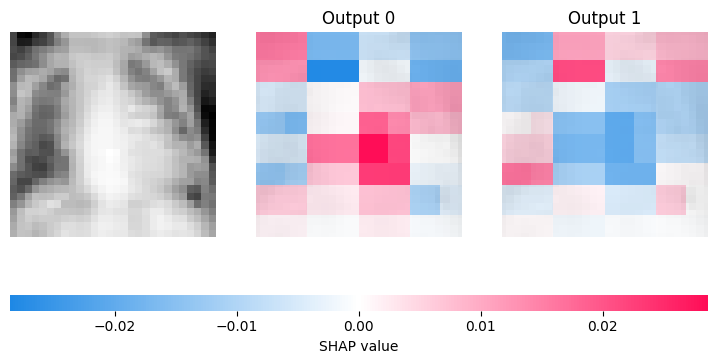

Image 1, True label: [0], Prediction 1


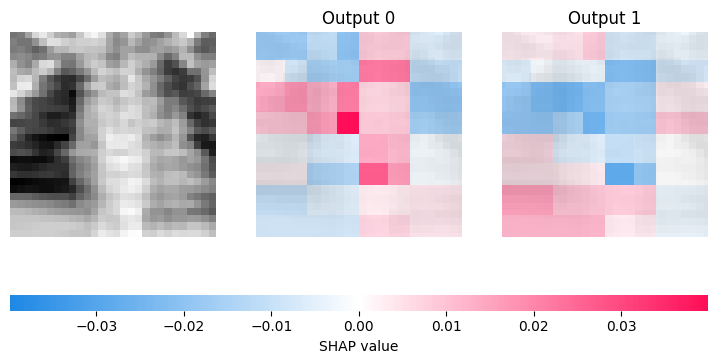

Image 3, True label: [0], Prediction 0


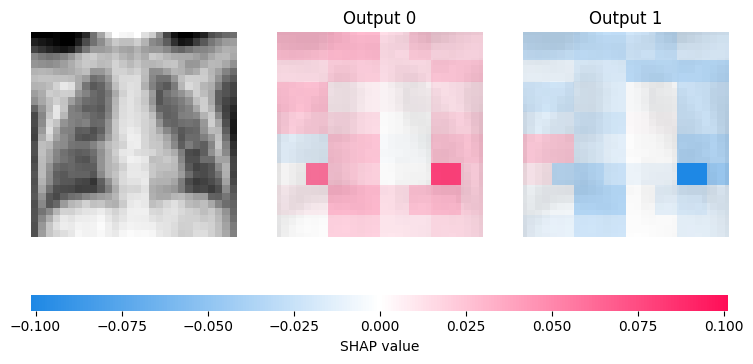

Image 102, True label: [1], Prediction 0


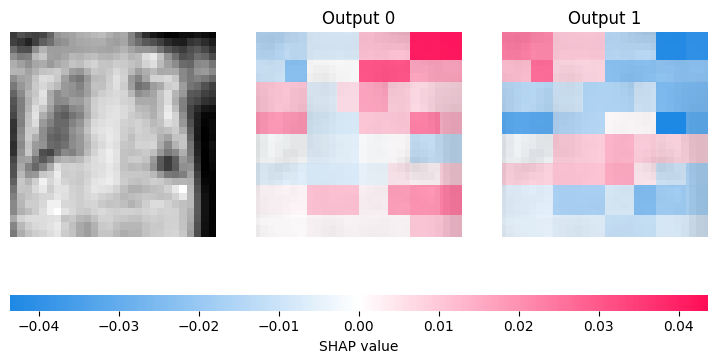

In [24]:
for idx in [tp_indices[0], fp_indices[0], tn_indices[0], fn_indices[0]]:
    
    img_tensor, label = test_dataset[idx]  # have to get images in tensor format rather than numpy as I did earlier
    
    # Convert to numpy for SHAP. Equivalent to code in above cell but going from tensor ->np rather than starting with np
    raw_img = img_tensor.numpy().transpose(1, 2, 0)  # → (28, 28, 1)
    
    # Run previous shap code
    shap_values=partitionshap(explainer=explainer, raw_img=raw_img, n_evals=n_evals)

    #bit inefficent here but there were some issues making sure i got the correct images and labes before.
    # I'm sure there are better ways but I fiddled around so much debugging as is
    y_pred, y_true, _ = pred_eval(split='test', evaluate=False, cm_indices=False)
    y_pred=y_pred[idx]
    print(f"Image {idx}, True label: {label}, Prediction {y_pred}")
    shap.image_plot(shap_values)

In [25]:
#Cleanup! Else my vram will die
#More or less hand picked via commented code
# import sys

# for name, obj in globals().items():
#     try:
#         print(name, sys.getsizeof(obj))
#     except:
#         pass


cleanup_vars = [
    # SHAP / explainers
    'masker_blur', 'explainer', 'shap_values', 'partitionshap',
    'model_explainer', 'model_shap_vals', 'model_shap_values',
    'layer1_explainer', 'layer1_shap_values',
    'layer4_explainer', 'layer4_shap_values',
    # ROC / evaluation
    'RocCurveDisplay', 'fpr', 'tpr', 'background_list',
    # Plot / intermediate tensors
    'plot_gradient_model', 'plot_1', 'plot_0',
    'plot_layer_1', 'plot_layer_4', 'partition_predict',
    'img_tensor', 'raw_img', 'test_images', 'test_images_plot'
]

# Delete variables
for var in cleanup_vars:
    if var in globals():
        del globals()[var]

# Force garbage collection
gc.collect()
torch.cuda.empty_cache()

## Deepexplainer

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FixedBasicBlock(nn.Module):
    """BasicBlock with non-inplace operations AND separate ReLU instances"""
    def __init__(self, original_block):
        super().__init__()
        self.conv1 = original_block.conv1
        self.bn1 = original_block.bn1
        # Create separate ReLU instances instead of reusing one
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = original_block.conv2
        self.bn2 = original_block.bn2
        self.relu2 = nn.ReLU(inplace=False)  # Second separate ReLU
        self.downsample = original_block.downsample
        self.stride = original_block.stride
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)  # Use first ReLU
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Non-inplace addition
        out = out + identity # THIS IS THE SPOT WHERE EVERYTHING GOT MESSED UP FOR SHAP!!!
        out = self.relu2(out)  # Use second ReLU
        
        return out

def fix_resnet_for_shap(model):
    """Replace all BasicBlocks with fixed versions"""
    def replace_blocks(module):
        for name, child in module.named_children():
            if child.__class__.__name__ == 'BasicBlock':
                setattr(module, name, FixedBasicBlock(child))
            else:
                replace_blocks(child)
    
    model_copy = copy.deepcopy(model)
    # Also fix any shared ReLU in the main model
    if hasattr(model_copy, 'relu'):
        model_copy.relu = nn.ReLU(inplace=False)
    
    replace_blocks(model_copy)
    return model_copy

# Use it
fixed_model = fix_resnet_for_shap(model)
fixed_model.eval()
fixed_model = fixed_model.to(device)

# Using 1/2 training images since we are in low resolution. This would be a bad idea otherwise from a computing perspective
indices = np.random.choice(len(train_dataset), len(train_dataset)//2, replace=False)
background = torch.stack([train_dataset[i][0] for i in indices]).to(device)

deep_exp = shap.DeepExplainer(fixed_model, background)


TP: Pred=1
Shap class 1


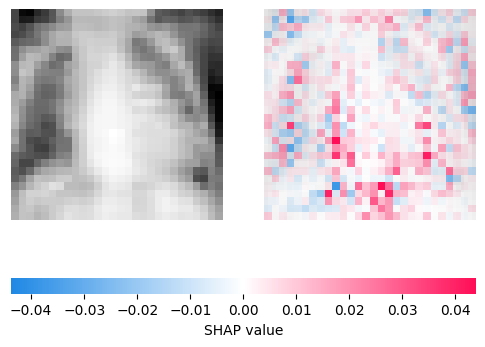

Shap class 0


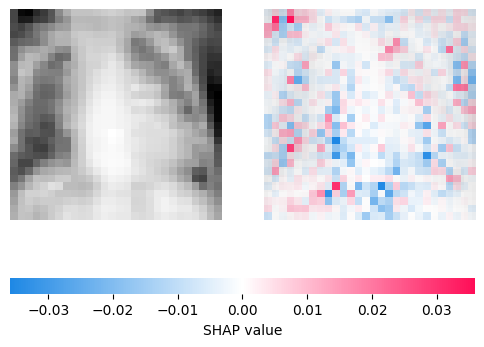

FP: Pred=1
Shap class 1


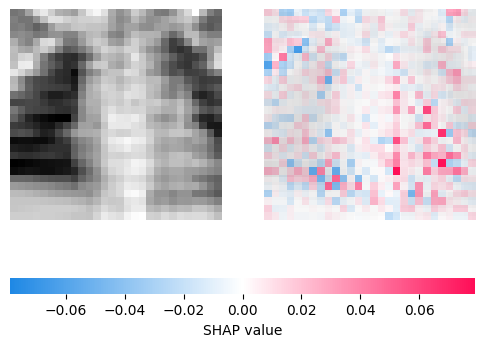

Shap class 0


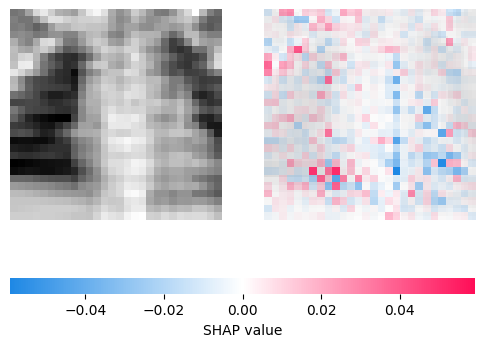

TN: Pred=0
Shap class 1


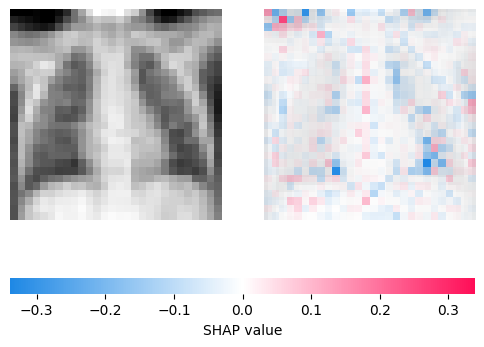

Shap class 0


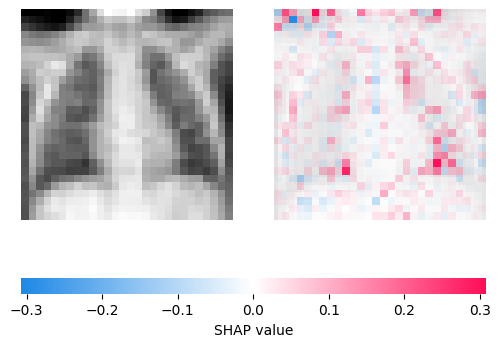

FN: Pred=0
Shap class 1


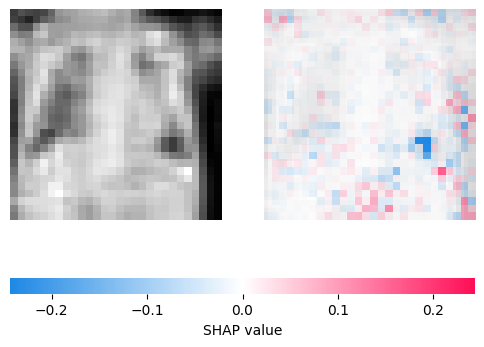

Shap class 0


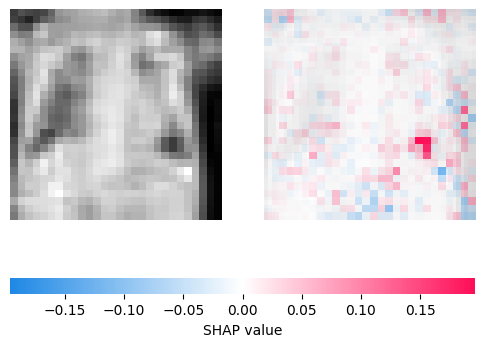

In [27]:
labelcounter=0
labels = ['TP: Pred=1', 'FP: Pred=1', 'TN: Pred=0', 'FN: Pred=0']

for idx in [tp_indices[0], fp_indices[0], tn_indices[0], fn_indices[0]]:
    
    img_tensor, label = test_dataset[idx]  # have to get images in tensor format rather than numpy as I did earlier
    #Storing tensors for running through explainer and therefore running through the modified forward pass with no inplace modification of gradients

    img_tensor=img_tensor.unsqueeze(0).cuda() #unsqueeze = np.newaxis

    #Fixing images for image plot. Shaping them to 1,28,28,1
    raw_img = img_tensor.cpu().numpy().transpose(0, 2, 3, 1)

    
    deep_shap_values = deep_exp.shap_values(img_tensor, check_additivity=False)
    # Check additivity is just listed as =True on docs. No mention what it does.
    # LLM suggested changing it to false when i had The "SHAP explanations do not sum up to the model's output!...
    # please post as a github issue, with a reproducible example so we can debug it." error.
    # The irony of needing an LLM you dont understand to parse the docs of an explainability package
    # https://stackoverflow.com/questions/68233466/shap-exception-additivity-check-failed-in-treeexplainer
    # Seems disabling this should make one weary of the absolute values but it shouldnt affect relative ranking
    # Meaning: Very red pixels are still more important than pink pixels.
    

    shap_reshaped = deep_shap_values.transpose(0, 2, 3, 1, 4) #Correct shape (1, 28, 28, 1, 2) 

    print(labels[labelcounter])
    labelcounter+=1
    print("Shap class 1")
    #image_plot + deepexplainer only seem to be able to display one class, I think its the predicted one unless you select one. 
    # Manually plotting both classes separately to see full picture
    #...And image_plot does not allow for plt.subplots
    #Sorry for wall of outputs but its all i can do at this point
    shap.image_plot(shap_reshaped[:,:,:,:,1],raw_img) #(1, 28, 28, 1, 1)  
    print("Shap class 0")
    shap.image_plot(shap_reshaped[:,:,:,:,0],raw_img)

In [28]:
#cleaning up some more memory

# Clear CUDA cache
try:
    cuda.select_device(0)
    cuda.close()
    torch.cuda.empty_cache()
except:
    pass

# Force garbage collection
import gc
gc.collect()

45445

<div class='alert alert-block alert-success' style="font-weight:bolder">

# Additional notes and learning required for solving this task

Slighly less formal language for learning expedience rather than academic polish

<div>

## Big resnets from "scratch"

I felt that I didn't understand what pytorch does. So i followed a video guide and made sure to comment everything I didn't understand.  
I feel roughly 50% more confident in using pytorch now!  


In [29]:
# code ref https://www.youtube.com/watch?v=DkNIBBBvcPs
# adjusted to fit 224 pnemoniamnist
# halved channel size because memory usage was too big for my vram in this long notebook
# also decreased batch size a bit

class hbblock(nn.Module):
    def __init__(self,in_channels, out_channels, identity_downsample=None, stride=1):
        #connections in, connections out, identity_downsample=we keep dimensions across skip connection stide=1 for convolution steps
        super(hbblock, self).__init__()
        self.expansion=4 #bottleneck block thing. Something about decreasing calculation size and then return to "normal" after a given block
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1, padding=0) #1st convolutional layer, doing normal jumps
        #kernel size= size of conv filter, 1 in this case is for cheap channel reduction 
        self.bn1 = nn.BatchNorm2d(out_channels) #z scale output keeping output dimensions
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=stride, padding=1) #double out channels to maintain size
        #2nd conv adds some padding and takes in stride argument in case end user wants to tune
        self.bn2 = nn.BatchNorm2d(out_channels) 
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0) #output will 4x the size after the bottleneck block
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU() #why did we learn of 10+ activation functions in last course when 90% is relu?
        self.identity_downsample = identity_downsample #changes x from skip connection to match block output
    
    def forward(self, x):
        identity=x #skip connection!
        #move x through all the layers in the block
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        x=self.conv3(x)
        x=self.bn3(x)

        #resize skip connection if needed
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x+= identity #AND THIS IS WHERE SHAP DEEPEXPLAINER BROKE! 
        #It wants x = identity + x since that is not an in place modification but im not sure why that breaks shap
        # reason for in place modification is so a new (BIG) tensor isnt created before the old one is deleted. 
        # So shap-ing a big nn will be extra intense
        #but I think you can do in place while training and re define forward when its time for shap
        x=self.relu(x)
        return x
    

class hbResNet(nn.Module): #class for "how many times will we use the block" [3,4,6,3]
    def __init__(self, hhblock,layers, img_channels, num_classes): #img_channels== grey=1, RGB=3, RGBA=4
        super(hbResNet, self).__init__()
        #first layer
        self.in_channels=64//2
        self.conv1=nn.Conv2d(img_channels, 64//2, kernel_size=7, stride=2, padding=3) #This should really shrink the calculations for next layer!
        self.bn1=nn.BatchNorm2d(64//2)
        self.relu=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #End of layer 1

        #ResNet layers
        self.layer1= self._create_layer(hbblock, layers[0],#now we can create a full block including forward pass starting with 1st layer wich has no downsampling
                                        out_channels=64//2, stride=1 ) #remember: out channels*4 in practice
        self.layer2= self._create_layer(hbblock, layers[1], #now we need downsampling
                                        out_channels=128//2, stride=2) #stride = 2 == downsampling for the nn.  Not just the x 
        self.layer3= self._create_layer(hbblock, layers[2], out_channels=256//2, stride=2)
        self.layer4= self._create_layer(hbblock, layers[3], out_channels=512//2, stride=2) #512*4 = 2048 channels. Thats a lot of channels!
        #let me rephrase the earlier violin plot visualization. Each distribution on the plot gets bigger and bigger
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4//2,n_classes)
        # NOTE All out channels are divided by 2 here to accomodate my laptop

    def forward(self, x):
        #first layer
        x= self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x= self.maxpool1(x)

        #time for bottleneck layers with all the convs inside!
        x=self.layer1(x) #loads of stuff happening here. Calls make_layer, wich calls hbblock multiple times and each block does 3 conv layers
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avgpool(x) #make sure x is correct shape [batch_size,2048,1,1]
        x=x.reshape(x.shape[0], -1) #makes x into vector [2048]
        x=self.fc(x) #normal nn time!

        return x

    def _create_layer(self, block, num_residual_blocks,out_channels, stride): #num_residual_blocks=number of times the layer will use a given block
        identity_downsample=None #basline is to not downsample, keep  the size
        layers=[]
        # have to make sure skip connection x is matching the output of a given block
        if stride != 1 or self.in_channels != out_channels*4:
            identity_downsample=nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, #making identy 4 times larger
                                                        kernel_size=1, stride=stride),
                                                        nn.BatchNorm2d(out_channels*4)) #making sure batch norm is matching as well
        #This is the layer that changes the number of channels    
        #layers.append(self.in_channels, out_channels, identity_downsample, stride)
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))


        self.in_channels=out_channels*4 #this will create a *4*4 (256) effect due to self.expansion in hbblock class
        # NOTE at this point I think one can visualize number of channels for a given a CNN with bottleneck layers sortof like a multimodal violin plot 
        
        #building more bottleneck blocks
        for i in range(num_residual_blocks-1): #-1 since one block is already created above
            layers.append(block(self.in_channels, out_channels, identity_downsample=None, stride=1))
            #start of block: inchannels= 256, out=64, end of block: out=64*4=56
        return nn.Sequential(*layers) #unpack the list for pytorch
    
def hbresnet50(img_channels=1, num_classes=2): #guide says img_channels=3 RGB and 1k classes but ill just start with ch=1,classes=2 for pneumoniamnist
    return(hbResNet(hbblock, [3,4,6,3],img_channels, num_classes))

    #The level of abstraction is actually insane here. Very cool
def hbresnet101(img_channels=1, num_classes=2):
    return(hbResNet(hbblock,[3,4,23,3],img_channels, num_classes))

def hbresnet152(img_channels=1, num_classes=2):
    return(hbResNet(hbblock, [3,8,36,3],img_channels, num_classes))


def test():
    net=hbresnet50()
    x=torch.randn(1,1,224,224)
    y=net(x).to("cuda")
    print(y.shape)

In [30]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Get dataset information
data_flag = 'pneumoniamnist'
info = INFO[data_flag]  # This gets the dataset metadata
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

lr=0.01
momentum=0.9

BATCH_SIZE = 128 #128 works!

# Define data preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image or numpy array to tensor
    transforms.Normalize(mean=[.5], std=[.5])  # Scale to [-1, 1] range
])

# Load the datasets
train_dataset = DataClass(split='train', transform=data_transform, download=True)  # Fixed: download=True
test_dataset = DataClass(split='test', transform=data_transform, download=True)  # Fixed: download=True


# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_loader_at_eval = data.DataLoader(
    dataset=train_dataset, 
    batch_size=2*BATCH_SIZE, 
    shuffle=False  # Usually False for evaluation
)

test_loader = data.DataLoader(
    dataset=test_dataset, 
    batch_size=2*BATCH_SIZE, 
    shuffle=False  # Usually False for testing
)



In [31]:
NUM_EPOCHS=2 #for testing
hbmodel=hbresnet50().cuda()


if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(hbmodel.parameters(), lr=lr, momentum=0.9)


for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    hbmodel.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = hbmodel(inputs.cuda())
        targets = targets.cuda()
        

        targets = targets.squeeze(1).long()
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

split = 'test'

hbmodel.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = hbmodel(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

100%|██████████| 37/37 [00:10<00:00,  3.61it/s]


test  auc: 0.600  acc: 0.625


## CNN terms and ideas
### Convolutional basics
Problems: Perturbation of images (tilted cats are also cats), correlated pixels (My whole head is one correlation of baldness!)  
Solution: Conv layers  
NN learns kernel filters. Each filter moves across image and calculates dot product for the whole matrix. Creating a feature map.  
Low dot product = low match ==filter pattern not present there (I am not bald in my beard even if its the face)  
High dot product = strong match == filter pattern detected at that location (SMH!)  
Filter values are relative to a given filter of a given network as they are learned during training so they might get crazy ranges.  
This is solved with batch norm though, and relu removes negative values also.  
Theoretically. Could one skip the max pooling and do sig normalization instead of relu. But this is probably stupid as no guides mention this.  

### Channels
“Channels” = feature matrices, each created by one filter.  
Each filter slides across the image (or feature map if we are past the first convolution), picking up features.  
This is called a convolution.  
That means an rgb image will go from 3 channels to n channels depending on how many channels specified in the network architecture.  
Each filter gets one weight for each row x column x channels.  
A 3x3 filter on a RGB image gets 28 weights which is fine.   
But a deeper convolutional network increases channels and a 3x3 filter on a previous convolution of 512 means 512 × 512 × 3×3 = 2,359,296 weights.  
This is why downsampling with stride =2 and bigger filters are done.  

### Pooling
Another filter! But generally jumps over feature matrix that wont overlap cells  
Either grabs max value covered by the filter  
Or averages all n x n feature values   
“Reduce the filter to the one spot where it did best matching the feature”  
Main goal: dimensionality reduction.  
Nice sideffect: Helps a bit with image perturbation  

This means that, at least simple, CNNs might only classify images on one or two features.


### Resnets and skip connections/residuals
Base case architecture: Layer1 – Layer2 + x from layer 1, repeat  
x adds itself to the output   
But during backprop its derivative turns into identity matrix, adding +1 to gradient signal   

The “residual” comes from the idea of that instead of doing the usual   
f(x)=y  
we do  
x+f(x)=y  
I got x, I want y, whats the difference between them f(x)?  
Calculation wise in nn forward pass? 0 difference in practice!  
Backpropagation though:  
y = f(x) + x → dL/dx = (dL/dy) * (df/dx + 1)  
This makes sense if we have a bunch of data and want to enhance or “extract the features” contributing to the prediction   
Deeper nns== bigger need for this idea (duh). Maybe cutof is around ~5 layers ish  
“Residual block” == Shorthand for "we add a skip connection between these layers"  
block=[Start skip [conv, batch norm, activation, conv, batch] add skip, activation]  

Residual regression nets have very much the same feeling as the definition of integral   
in the sense that we add a tiny step to the curve on our regression line.  
xk+1=xk+f(xk)  


### Transfer learning for neural networks

In anutshell is it just taking the architechture, weights and biases of an already trained nn that solves a similar task.   
Freeze as many weights and biases as possible, change the output targets.  
Run a small n epochs (5-100 depedning on domain) on your new inputs.  
Then you iterate by unfreezing and tweaking one layer at a time working backwards. A backward-tweak!  

More on transfer learning since we had 0 lectures on this topic  
https://cs231n.github.io/transfer-learning/  
Small dataset – similar to original: Freeze all conv and train the final layer. Huge overfitting risk.  
Large dataset – similar to original: Can probably work through the whole NN. Be empirical and minful of overfitting.  
Small dataset – dissimilar to original: Either just train final layer, train middle layers (maintain edge detection filters in the beginning) or both.  
Big dataset – dissimilar to the original: If you have money and time: Do a new nn from scratch. Save money by using a dissimilar pretrained nn   anyway. There are resources for pretrained weights out there: https://github.com/BVLC/caffe/wiki/Model-Zoo  


LR should probably be smaller than baseline since weights might be too perturbed otherwise.   
Analogy in my head: We are running the final few epochs and lr_decay=True   
Presumably the same holds true for momentum  
Couldnt find anything on batch size that is on a level for a 2nd year undergrad to understand.  
But my thought process goes like this:  
Small dataset and frozen layers means we only adjust a few weights and increase the risk of overfitting.  
Smaller batches = more stochastically == Less risk of overfitting  
But I have no way of verifying wether this is correct or not at my current level.

Doing epochs last to go to the overfitting edge

## Shap

### General pytorch --> shap.image_plot process
What shap.image_plot() wants:  
Shape: (N, H, W, C) - C=channels  
Values: [0, 1] range for display  
Format: Numpy arrays  

What PyTorch outputs:  
Shape: (N, C, H, W) - channels first, and C=1 for grayscale  
Values: Often normalized (mean/std), not [0, 1]  
Format: Tensors (need .cpu().numpy())  

What Keras github” examples outputs:  
Shape: (N, H, W, 3) - channels last,  
Values: Usually [0, 1] already   
Format: Numpy arrays  

Tinfoil hat take on why the docs mostly show Keras:  
It just works with their expected format. No conversion needed.  

Fix:  
Convert tensor → numpy  
Remove C (1 dim) with squeeze (N, H, W)  
Denormalize to [0, 1]  
Add last channel [:, :, :, np.newaxis] on both image array and shap vals  
Now image_plot() is happy!  
TL;DR: SHAP was built for Keras. PyTorch needs manual wrangling because formats don't match.  

## Partitionexplainer 
What happens to prediction when we blur/mask pixels = marginal pixel contribution = pixelshap!  
max_evals 2x2 image base case:  
if max_evals=1:  
randomly blur/mask 1 pixel combination that might mean pixel 0,0 or 0,1 + 1,1 etc   
2x2 image has 4 pixels → 2⁴ = 16 pixel combinations  
meaning max_eval should idealy cover a big portion of the combination space.  
Sadly explainer code does not seem to keep track of previously used combos so one should probably do even higher than pixel combinations.  
Wich would end up with 2 ^ (h x w) == perturbed/unperturbed raised to the power of n_pixel =>Sample space larger than the universe!  

The counter to that is to create “superpixels” that seem to be aggregations of pixels so sample space don’t go too crazy  
Superpixels correspond to arguments in shap.maskers.image()  
But im unsure of the exact details and documentation is...opaque (wich is ironic given the goal of shap)  
Still, in general, more max_evals = better explanations. But that eats time and memory.  

Practical question partitionexplainer answers: *Is the model looking at the correct pixels?*  
General rule of thumb: More intense pixels = more confident model  
For each class:  
  Sum up all the SHAP values (red positive, blue negative)  
Class with highest total sum = predicted class  

Same vibes as Naive Bayes!:  
  P(class) ∝ product of feature probabilities  
  Highest probability wins  
SHAP:  
  prediction ≈ base_value + sum of SHAP values  
  Highest prediction wins  

## Gradientexplainer
Slightly hand wavy explanation  
"Background images usually do this to the network  
How does my image compare to that"  

Slighly less handwavy but still not 100% correct  
The process is more or less the same as partitionexplainer.   

Randomly select images from background set  
Make a random blend with the image of interest.  
Analyze what happens through the network with the blended image.  

Rerun this several times with replacement and random % blending.  
Average results leads to shap values  


## Quick colorblind modification

~5% of the population is color blind and red/green is the most common form to my knowledge.  
This is a potential issue in clinical settings where either clinician or patients might be color blind  
and have issues interpreting the shades of grey overlaid ontop of grescale X-rays.  
Shap image plotting doesn't seem to integrate with standard Python visualization libraries (matplotlib/seaborn),  
making it difficult to implement colorblind-friendly palettes.  

This is just a rough idea one could fire up quickly and project next to the plot_image output should the need arise  

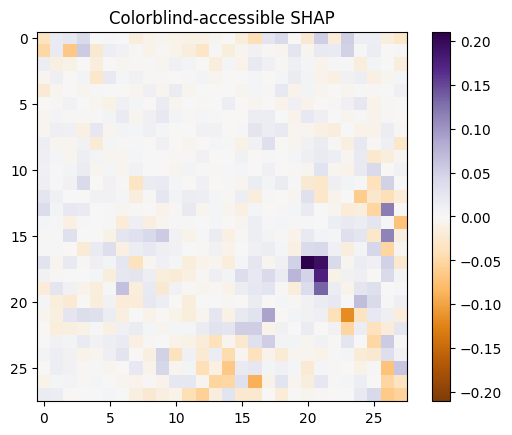

In [32]:
#just grabbing the last shap values from deepexplainer FN image in this case
colorblind_shaps=deep_shap_values.squeeze() #Nooo im removing the wrangled dimensions!
fig, ax = plt.subplots()
im = ax.imshow(colorblind_shaps[:,:,0], cmap='PuOr', 
               vmin=-np.abs(colorblind_shaps[:,:,0]).max(), #lower bound
               vmax=np.abs(colorblind_shaps[:,:,0]).max()) #upper bound
ax.set_title("Colorblind-accessible SHAP")
plt.colorbar(im)
plt.show()

## Deepexplainer

Deepexplainer uses neurons and conv/pool indices during backpropagation to approximate shap vals  
It works by comparing each neuron's activation for your image to its activation for a "neutral"** baseline image.   
The difference is then calculated as weight * (change from neutral) back through the network's connections to the input pixels.  
The same way gradientexplaioner does – Loads of assumptions there!  
Inference: Deepexplainer should get worse as nn gets deeper  

**"Neutral" depends on the question asked. "What differs from healthy lungs?" Use only healthy images.  
I simply chose half my dataset as I didnt quite know these details.

## Shap.Deepexplainer and pytorch workaround  
Reference for issue and workaround:  
https://github.com/shap/shap/issues/3466  

Main issue: Pytorch uses in place modification of gradients in order to save memory.  

Fix:  
Make a custom forward pass and modify the out/x in place modifications  
out = out + identity  
Modify relu to not do in place modification  
self.relu1 = nn.ReLU(inplace=False)  

Write custom function to modify all relus and in place modifications of out/x.  

Apparently x+=1 is an in place modification whereas x= x+1 is not.  

This was figured out with a lot of help from an LLM where I searched github and provided screenshots of provided solutions.   
So all code regarding modifying the model for deepexplainer, apart from a few comments, is pure LLM vibecoding and way above my skill level.  